# Vulnerability analysis

This notebook contains analysis of vulnerabilities in Common Criteria certificates. 

## Executive summary

- We exclude the current year (2022) from analyses when possible, search for `2022` to see the relevant places
- We exclude the vulnerabilities that affect a product *prior* to certification in the following cases:
    - Correlation analysis of SARs, EALs vs number/severity of vulnerabilities
    - CWE analysis
    - Time from CVE to maintenance update

- Weak correlations (in a sensible direction, i.e., negative correlations) between expert-selected SARs that could correspond to more secure products and number/severity of vulnerabilities. Same correlations exist on more coarser scale of EALs
- Maintenannce updates very rarely used to address vulnerabilities. Instead, they often make claims about vulnerabilities not being applicable to the *certified version* of the product. The rationale is often mentioned in the non-public Impact Analysis Report
- Approximately 50% of vulns. exist prior to certification, these are seldomly referenced in the certificatation documents (TODO: double-check). 
- In combination with dependency map between certificates, the ecosystem is quite fragile, as a single vulnerability on average affects X certs directly and Y certs indirectly
- Some categories heavily underrepresented in the CPE/CVE landscape, e.g., smartcards

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from tqdm.notebook import tqdm
from sec_certs.cert_rules import cc_rules
import itertools
from scipy import stats
import functools

from typing import Set
from sec_certs.sample.sar import SAR
plt.style.use("seaborn-whitegrid")
sns.set_palette("deep")
sns.set_context("notebook") # Set to "paper" for use in paper :)
 
from sec_certs.dataset import CCDataset, CVEDataset, CCDatasetMaintenanceUpdates, CPEDataset
from sec_certs.sample import CommonCriteriaCert
from sec_certs.utils.helpers import download_file
import datetime
import tempfile
from bs4 import BeautifulSoup

from pathlib import Path
import itertools

from sec_certs.utils.pandas import compute_cve_correlations, find_earliest_maintenance_after_cve, expand_cc_df_with_cve_cols, compute_maintenances_that_come_after_vulns, move_fixing_mu_to_directory, prepare_cwe_df, get_top_n_cwes, get_sar_level_from_set, discover_sar_families

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

RESULTS_DIR = Path("./results")
RESULTS_DIR.mkdir(exist_ok=True)

## Retrieve necessary objects from sec-certs

In [2]:
# Local instantiation
dset = CCDataset.from_json("/Users/adam/phd/projects/certificates/sec-certs/datasets/cc_04_10_2022/cc_09_10_2022.json")
# dset.process_maintenance_updates() # Run this only once, can take ~10 minutes to finnish, fully processes maintenance updates
main_dset = dset.mu_dataset
cve_dset: CVEDataset = dset._prepare_cve_dataset()
cpe_dset: CPEDataset = dset._prepare_cpe_dataset()

# Remote instantiation
# dset: CCDataset = CCDataset.from_web_latest()
# # main_dset: CDatasetMaintenanceUpdates = CCDatasetMaintenanceUpdates.from_web_latest()
# cve_dset: CVEDataset = CVEDataset.from_web()

parsing cpe matching (by NIST) dictionary: 100%|██████████| 398394/398394 [00:51<00:00, 7800.54it/s] 
Building-up lookup dictionaries for fast CVE matching: 100%|██████████| 197102/197102 [00:18<00:00, 10595.28it/s]


### Dataset preprocessing

- Loads `CCDataset` into pandas DataFrame
- Expands it with various maintenance-related columns
- Expands it with various CVE-related columns

In [3]:
df = dset.to_pandas()

if 'n_maintenances' not in df.columns:
    n_maintenances = main_dset.get_n_maintenances_df()
    df = pd.concat([df, n_maintenances], axis='columns')

if 'maintenance_dates' not in df.columns:
    main_dates = main_dset.get_maintenance_dates_df()
    df = pd.concat([df, main_dates], axis='columns')

# Expand DataFrame with CVEs that affect some certificate
cves = list(itertools.chain.from_iterable([x.heuristics.related_cves for x in dset if x.heuristics.related_cves]))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict # Limit cve_dset to CVEs relevant to some certificate
df = expand_cc_df_with_cve_cols(df, cve_dset)
df_cves_within_validity_period = expand_cc_df_with_cve_cols(df.loc[(df.not_valid_before.notnull()) & (df.not_valid_after.notnull())].copy(), cve_dset, filter_to_cves_in_validity_period=True)

df_cpe_rich = df.loc[~df.cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.n_cves > 0].copy()

In [4]:
# Take a look at columns related to CVEs
df.loc[~df.related_cves.isna(), ['related_cves', 'cve_published_dates', 'earliest_cve', 'worst_cve_score', 'avg_cve_score']]

,related_cves,cve_published_dates,earliest_cve,worst_cve_score,avg_cve_score
ebd276cca70fd723,"{CVE-2013-5420, CVE-2013-5421, CVE-2019-4513, ...","[2013-12-23, 2013-12-22, 2019-08-26, 2018-08-1...",2013-12-22,10.0,5.800000
3dc6e1ebe7dd5584,"{CVE-2022-40709, CVE-2022-40710, CVE-2021-2525...","[2022-09-28, 2022-09-28, 2021-03-03, 2022-09-2...",2021-03-03,7.8,4.640000
b7f814ed16f2ecca,{CVE-2018-8753},[2018-08-15],2018-08-15,5.9,5.900000
c290ee3692a00006,"{CVE-2019-12255, CVE-2019-12263, CVE-2019-7487...","[2019-08-09, 2019-08-09, 2019-12-19, 2019-08-0...",2019-08-09,9.8,8.075000
4fc1208e4c800aa6,"{CVE-2017-14616, CVE-2017-14615}","[2017-09-20, 2017-09-20]",2017-09-20,7.5,6.800000
...,...,...,...,...,...
fca440a973659369,"{CVE-2010-0769, CVE-2006-6136, CVE-2007-4833, ...","[2010-04-01, 2006-11-28, 2007-09-12, 2009-07-1...",2006-08-14,10.0,5.425000
bf0f130ebce2e124,"{CVE-2010-0769, CVE-2007-4833, CVE-2009-0217, ...","[2010-04-01, 2007-09-12, 2009-07-14, 2010-05-0...",2005-11-04,10.0,5.710390
686005d0b5ff5c5c,"{CVE-2010-0769, CVE-2007-4833, CVE-2009-0217, ...","[2010-04-01, 2007-09-12, 2009-07-14, 2010-05-0...",2005-05-02,10.0,5.904348
5f1df5ad8e51ba75,"{CVE-2005-4704, CVE-2005-4752, CVE-2005-4749, ...","[2005-12-31, 2005-12-31, 2005-12-31, 2005-05-2...",2003-08-27,10.0,5.594565


## Plots

- distribution of categories in CPE-rich vs. all certificates
- distribution of years in CPE-rich, CVE-rich, and all certificates
- distribution of security levels in CPE-rich, CVE-rich and all certificates
- distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates

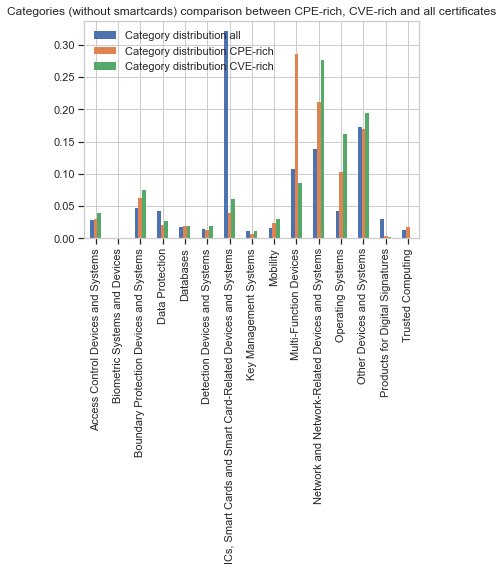

<Figure size 432x288 with 0 Axes>

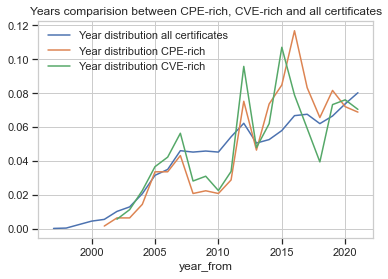

<Figure size 432x288 with 0 Axes>

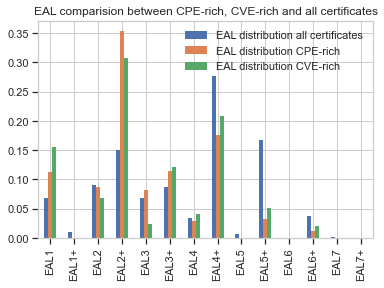

<Figure size 432x288 with 0 Axes>

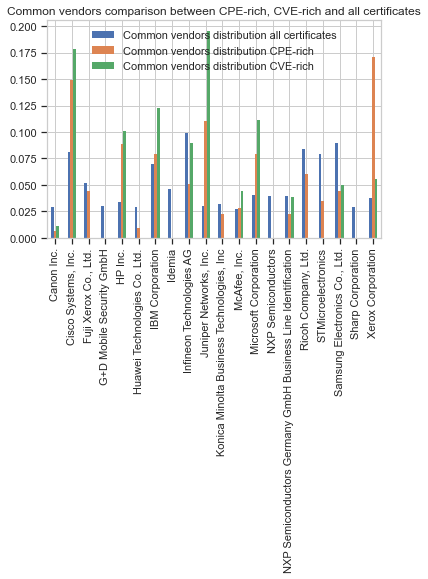

<Figure size 432x288 with 0 Axes>

In [5]:
# distribution of categories in CPE-rich vs. all certificates
categories_cpe = df_cpe_rich.category.value_counts().sort_index().rename('Category distribution CPE-rich')
categories_cve = df_cve_rich.category.value_counts().sort_index().rename('Category distribution CVE-rich')
categories_all = df.category.value_counts().sort_index().rename('Category distribution all')

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)

categories_merged.plot.bar(title='Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates')
plt.show()
plt.savefig(RESULTS_DIR / "categories.pdf", bbox_inches='tight')

# distribution of years in CPE-rich, CVE-rich, and all certificates
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename('Year distribution CPE-rich')
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename('Year distribution CVE-rich')
years_all = df.year_from.value_counts().sort_index().rename('Year distribution all certificates')

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged.index.name = "year_from"
years_merged = years_merged.loc[years_merged.index < 2022]
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title='Years comparision between CPE-rich, CVE-rich and all certificates')

plt.show()
plt.savefig(RESULTS_DIR / "cve_cpe_certs_time_evolution.pdf", bbox_inches='tight')

# distribution of security levels in CPE-rich, CVE-rich and all certificates
levels_cpe = df_cpe_rich.eal.value_counts().sort_index().rename('EAL distribution CPE-rich')
levels_cve = df_cve_rich.eal.value_counts().sort_index().rename('EAL distribution CVE-rich')
levels_all = df.eal.value_counts().sort_index().rename('EAL distribution all certificates')

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title='EAL comparision between CPE-rich, CVE-rich and all certificates')
plt.show()
plt.savefig(RESULTS_DIR / "eal_distr_all_cpes_cves.pdf", bbox_inches='tight')

# distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates
top_manufacturers = list(df.manufacturer.value_counts().head(20).index)
vendors_cpe = df_cpe_rich.loc[df_cpe_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CPE-rich')
vendors_cve = df_cve_rich.loc[df_cve_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CVE-rich')
vendors_all = df.loc[df.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution all certificates')

vendors_merged = pd.concat([vendors_all, vendors_cpe, vendors_cve], axis=1)
vendors_merged = vendors_merged.div(vendors_merged.sum(axis=0), axis=1)
vendors_merged.plot.bar(title='Common vendors comparison between CPE-rich, CVE-rich and all certificates')
plt.show()
plt.savefig(RESULTS_DIR / "top_vendors_vulns.pdf", bbox_inches='tight')

## Correlations between (EAL, SAR) and CVEs

In [6]:
# This limits analysis to SAR families that are popular-enough (>100 CVE-rich certs, second-most-popular value with >= 40 instances)
cve_rich = df_cves_within_validity_period.loc[df_cves_within_validity_period.related_cves.notnull()].copy()
families = discover_sar_families(cve_rich.extracted_sars)

for family in tqdm(families):
    cve_rich[family] = cve_rich.extracted_sars.map(lambda x: get_sar_level_from_set(x, family))

sars = cve_rich[families].notnull().sum().to_frame("support")
sars.index.name = "family"
sars["second_most_popular"] = sars.index.map(lambda x: 0 if not len(cve_rich[x].value_counts()) > 1 else cve_rich[x].value_counts().iloc[1])
sars = sars.loc[(sars.support >= 100) & (sars.second_most_popular >= 40)].sort_values(by="support", ascending=False)
sars["range"] = sars.index.map(lambda x: len(cve_rich[x].value_counts()))

df_corr = compute_cve_correlations(df_cves_within_validity_period.loc[df_cves_within_validity_period.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems"], sar_families=sars.index.tolist(), filter_nans=False)
df_corr["range"] = sars["range"]
df_corr.loc["eal", "range"] = len(cve_rich.eal.cat.categories)
df_corr = df_corr.sort_values(by="avg_cve_score_corr").rename(index={"eal":"EAL"}).drop(columns=["worst_cve_score_corr", "worst_cve_pvalue"])
df_corr = pd.concat([df_corr.loc["EAL", :].to_frame().transpose(), df_corr.drop("EAL")])
df_corr.range = df_corr.range.astype("int")
df_corr.support = df_corr.support.astype("int")
df_corr.index.name = "EAL/SAR family"
df_corr.index = df_corr.index.map(lambda x: x.replace("_", "\_"))
df_corr.to_csv(RESULTS_DIR / "certs_without_smartcards_sar_cve_corr.csv", float_format="%.2e")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
df_corr

,n_cves_corr,n_cves_pvalue,avg_cve_score_corr,avg_cve_pvalue,support,range
EAL/SAR family,,,,,,
EAL,-0.026750,7.929923e-02,-0.348873,2.526833e-07,2779,14
ALC\_CMC,-0.102765,3.222375e-07,-0.368044,4.122288e-08,2336,5
ALC\_CMS,-0.099041,7.843342e-07,-0.367196,4.436660e-08,2342,5
AVA\_VAN,-0.108667,5.797582e-08,-0.351478,1.787198e-07,2367,4
ATE\_IND,-0.083390,1.772333e-06,-0.328926,2.223989e-08,3083,3
ATE\_COV,-0.020569,1.621168e-01,-0.317541,2.026090e-05,2299,3
ADV\_FSP,-0.079044,4.737295e-06,-0.279932,2.007287e-06,3132,6
ASE\_OBJ,-0.115048,3.066473e-07,-0.137514,4.145539e-02,1869,2
ASE\_REQ,-0.117490,1.336536e-07,-0.119977,6.297902e-02,1907,2


## Time from CVE to maintenance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE may be related to that vulnerability
- The sample size is small. Only ~40 certificates have at least one CVE and at least one Maintenance update. Out of those, only ~30 certificates have maintenance update that comes after a CVE

In [8]:
df_main_after_vuln = compute_maintenances_that_come_after_vulns(df_cves_within_validity_period)

n_vuln_certs_wo_maintenances = df_cves_within_validity_period.loc[(df_cves_within_validity_period.n_cves>0) & (df_cves_within_validity_period.n_maintenances==0)].shape[0]
n_vuln_certs_w_maintenances = df_cves_within_validity_period.loc[(df_cves_within_validity_period.n_cves>0) & (df_cves_within_validity_period.n_maintenances>0)].shape[0]
n_certs_with_main_after_vuln = df_main_after_vuln.loc[df_main_after_vuln.earliest_maintenance_after_vuln.notna()].shape[0]

print(f'Number of certificates with >0 CVEs in validity period but 0 maintenance reports: {n_vuln_certs_wo_maintenances}')
print(f'Number of certificates with >0 CVEs in validity period and >0 maintenance reports: {n_vuln_certs_w_maintenances}')
print(f'Number of vulnerable certificates with a maintenance report *after* CVE: {n_certs_with_main_after_vuln}')

updates_that_should_fix_vulns_path = RESULTS_DIR / "updates_that_should_fix_vulns"
updates_that_should_fix_vulns_path.mkdir(exist_ok=True)
mu_filenames = move_fixing_mu_to_directory(df_main_after_vuln, main_dset.to_pandas(), updates_that_should_fix_vulns_path, "/Users/adam/phd/projects/certificates/sec-certs/datasets/cc_04_10_2022/certs/maintenances/reports/pdf")

Number of certificates with >0 CVEs in validity period but 0 maintenance reports: 0
Number of certificates with >0 CVEs in validity period and >0 maintenance reports: 14
Number of vulnerable certificates with a maintenance report *after* CVE: 7


In [9]:
df_main_after_vuln.loc[df_main_after_vuln.earliest_maintenance_after_vuln.notna(), ["maintenance_dates", "earliest_cve", "earliest_maintenance_after_vuln"]]

,maintenance_dates,earliest_cve,earliest_maintenance_after_vuln
dgst,,,
c57b9308028caccf,"[2019-12-18, 2018-08-03]",2019-01-24,2019-12-18
822d871f3bbd06d7,[2021-09-29],2020-07-17,2021-09-29
b3f6140720637831,"[2013-12-06, 2014-12-08, 2014-12-08]",2014-03-18,2014-12-08
d7496d93563c3bea,[2014-12-19],2013-10-13,2014-12-19
16f1a518cd842fcb,"[2014-05-14, 2013-05-30, 2013-10-10]",2013-07-18,2013-10-10
44fafadf91cbbc96,[2019-08-20],2018-04-30,2019-08-20
c25126449c82fe65,[2018-12-08],2016-06-04,2018-12-08


## Histogram timeline of new vulnerabilities

Shows when vulnerabilities are announced in relation to the date of certification & date of certificate expiration.

*Note*: Some certificates (especially the new ones) don't have their expiration date set yet. These are discarded from the analysis.

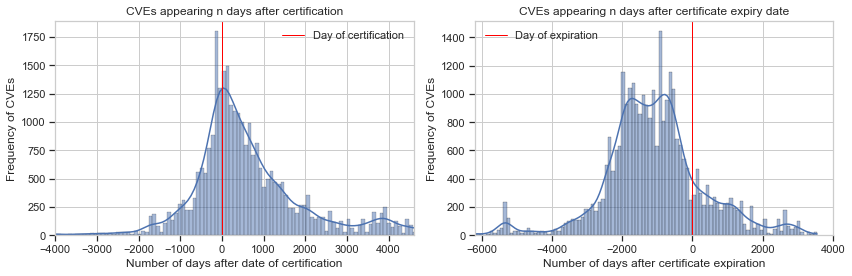

Ratio of CVEs appearing before (or exactly on) certification date: 32.14%
Ratio of CVEs appearing after certification date: 67.86%


In [10]:
exploded_cves = df_cve_rich.explode("related_cves").loc[:, ["related_cves", "not_valid_before", "not_valid_after"]].rename(columns={"related_cves": "cve"})
exploded_cves = exploded_cves.dropna()
exploded_cves["cve_published_date"] = exploded_cves.cve.map(lambda x: cve_dset[x].published_date)

exploded_cves.not_valid_before = exploded_cves.not_valid_before.dt.normalize()
exploded_cves.not_valid_after = exploded_cves.not_valid_after.dt.normalize()
exploded_cves.cve_published_date = exploded_cves.cve_published_date.dt.tz_localize(None).dt.normalize()

exploded_cves["n_days_after_certification"] = (exploded_cves.cve_published_date - exploded_cves.not_valid_before).dt.days
exploded_cves["n_days_after_expiry"] = (exploded_cves.cve_published_date - exploded_cves.not_valid_after).dt.days

plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.autolayout"] = True
figure, axes = plt.subplots(1, 2)

exploded_cves.to_csv(RESULTS_DIR / "exploded_cves.csv")

hist = sns.histplot(exploded_cves.n_days_after_certification, kde=True, ax=axes[0])
hist.set(xlim=(-4000,4600), title="CVEs appearing n days after certification", xlabel="Number of days after date of certification", ylabel="Frequency of CVEs")
hist.axvline(0, color="red", linewidth="1", label="Day of certification")
hist.legend(loc="upper right")
# plt.savefig(RESULTS_DIR / "cves_n_days_after_certification.pdf", bbox_inches='tight')
# plt.show()

hist = sns.histplot(exploded_cves.n_days_after_expiry, kde=True, ax=axes[1])
hist.set(xlim=(-6200, 4000), title="CVEs appearing n days after certificate expiry date", xlabel="Number of days after certificate expiration", ylabel="Frequency of CVEs")
hist.axvline(0, color="red", linewidth="1", label="Day of expiration")
hist.legend(loc="upper left")
plt.savefig(RESULTS_DIR / "cves_vs_certificate_lifetime.pdf", bbox_inches='tight')
plt.show()

n_cves = exploded_cves.shape[0]
ratio_before_cert = exploded_cves.loc[exploded_cves.n_days_after_certification <= 0].shape[0] / n_cves
ratio_after_cert = exploded_cves.loc[exploded_cves.n_days_after_certification > 0].shape[0] / n_cves
print(f"Ratio of CVEs appearing before (or exactly on) certification date: {100 * ratio_before_cert:.2f}%")
print(f"Ratio of CVEs appearing after certification date: {100 * ratio_after_cert:.2f}%")

## How many CVE-rich certificates were revoked within <365 days after certification

In [11]:
maybe_revoked = df_cve_rich.loc[~df_cve_rich.not_valid_after.isna(), ["not_valid_before", "not_valid_after", "n_cves", "worst_cve_score", "avg_cve_score", "related_cves"]]
maybe_revoked["validity_n_days"] = (maybe_revoked.not_valid_after - maybe_revoked.not_valid_before).dt.days
maybe_revoked = maybe_revoked.loc[maybe_revoked.validity_n_days < 365]
print(f'How many CVE-rich certificates were revoked in <365 days after certification: {maybe_revoked.shape[0]}')

df_w_validity_dates = df.loc[~df.not_valid_after.isna()].copy()
df_w_validity_dates.loc[:, "validity_n_days"] = (df_w_validity_dates.not_valid_after - df_w_validity_dates.not_valid_before).dt.days
df_w_validity_dates = df_w_validity_dates.loc[df_w_validity_dates.validity_n_days < 365]
print(f'How many certificates were revoked in <365 days after certification: {df_w_validity_dates.shape[0]}')
print(f"How many certificates have expiry date same as certification date: {df_w_validity_dates.loc[df_w_validity_dates.not_valid_before == df_w_validity_dates.not_valid_after].shape[0]}")

How many CVE-rich certificates were revoked in <365 days after certification: 2
How many certificates were revoked in <365 days after certification: 39
How many certificates have expiry date same as certification date: 21


In [12]:
df_w_validity_dates.loc[:, ["name",  "not_valid_before", "not_valid_after", "validity_n_days", "related_cves"]].sort_values(by="validity_n_days", ascending=False)

,name,not_valid_before,not_valid_after,validity_n_days,related_cves
602f65f51a07adaf,"Brocade Communications Systems, Inc. Brocade D...",2015-03-25,2016-03-21,362,NaN
a7120da6bf4874fa,"DigiSAFE Data Diode model 3282 version 2.2, mo...",2019-06-17,2020-06-10,359,NaN
e2f3a1cdd592ab05,"Cisco 800, 1900, 2900, 3900 Series Integrated ...",2011-07-31,2012-07-20,355,NaN
f410930a2a47d3d0,"Avaya VSP 4000, VSP 7000 and VSP 8000",2017-03-10,2018-02-26,353,NaN
16bdbde359584f99,Xaica-α PLUS ePassport on MTCOS Pro 2.5 with S...,2019-01-25,2019-12-03,312,NaN
0c7ef6c32cbdee47,Xaica-α PLUS ePassport on MTCOS Pro 2.5 with S...,2019-01-25,2019-12-03,312,NaN
3c24bbe7724dbfdd,"McAfee® Email Gateway (MEG) software v7.0.1, r...",2012-10-16,2013-08-21,309,"{CVE-2012-4585, CVE-2012-4582, CVE-2020-7268, ..."
9e0ec9db58b5c8ec,RICOH MP C306Z J-1.01,2016-04-25,2017-02-13,294,NaN
5068c3b7fefae589,bizhub C652 / bizhub C652DS / bizhub C552 / bi...,2010-06-29,2011-04-15,290,NaN
25fcafd838cecd84,bizhub C360 / bizhub C280 / bizhub C220 / bizh...,2010-06-29,2011-04-15,290,NaN


## Scatterplot of CVE severity w.r.t. categories

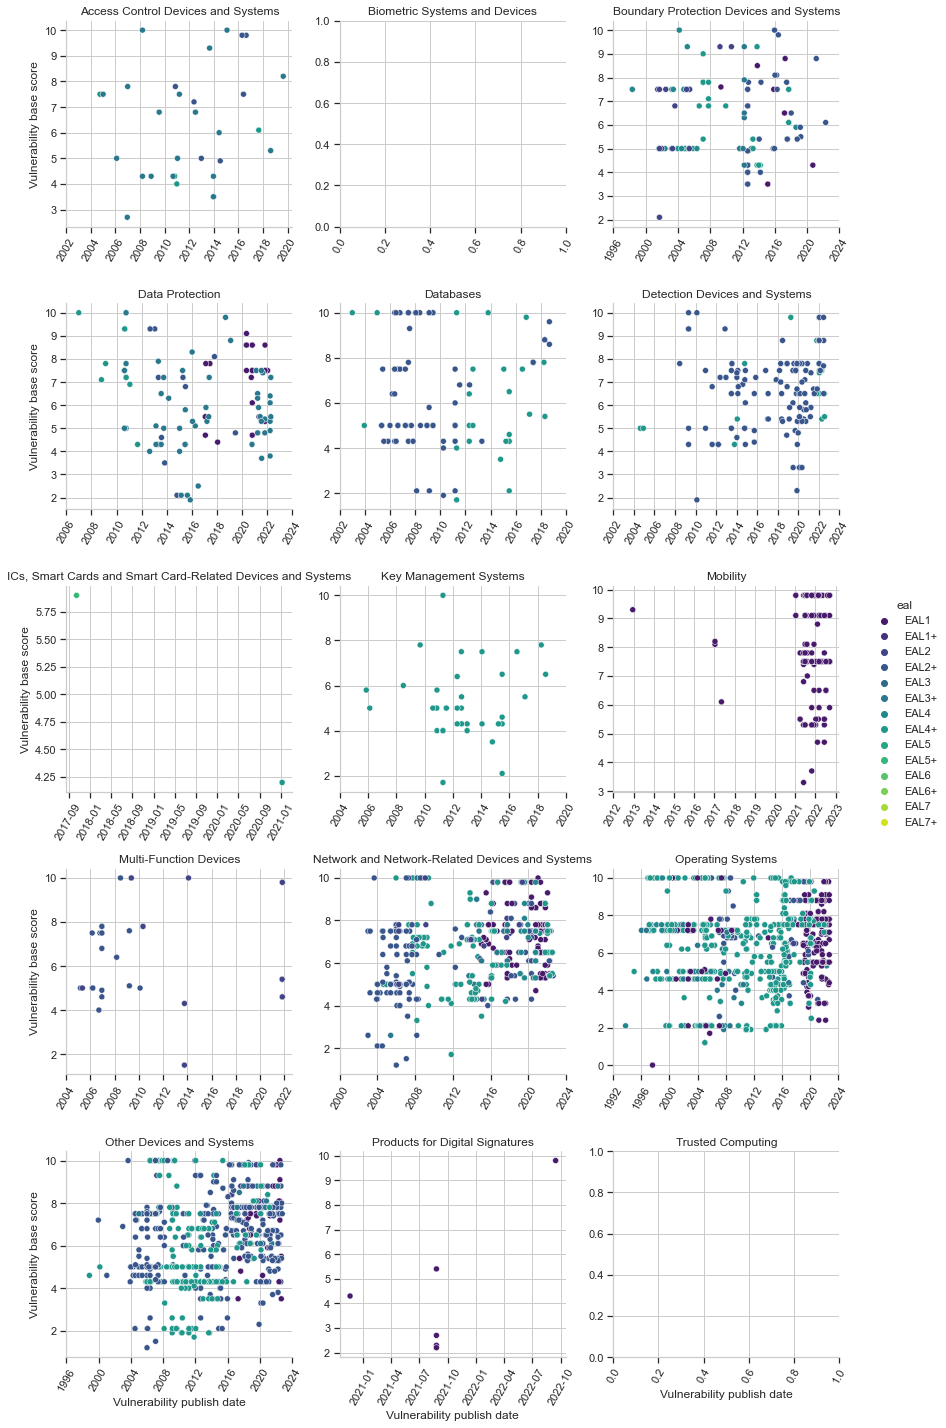

In [13]:
n_cves_top_20_certs = df_cve_rich.n_cves.sort_values(ascending=False).head(20)[-1]
cves = df_cve_rich.loc[(df_cve_rich.year_from < 2022) & (df_cve_rich.n_cves < n_cves_top_20_certs) & (~df_cve_rich.eal.isna()), ["related_cves", "eal", "category"]].explode("related_cves").rename(columns={"related_cves": "cve_id"})
cves["published_date"] = cves.cve_id.map(lambda x: cve_dset[x].published_date).dt.tz_localize(None).dt.normalize()
cves["base_score"] = cves.cve_id.map(lambda x: cve_dset[x].impact.base_score)
cves = cves.drop_duplicates()

g = sns.relplot(data=cves, x="published_date", y="base_score", hue="eal", col="category", col_wrap=3, height=4, kind="scatter", facet_kws={"sharey": False, "sharex": False}, palette="viridis")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=60)
g.set_axis_labels("Vulnerability publish date", "Vulnerability base score")
g.tight_layout()
plt.savefig(RESULTS_DIR / "scatter_category_vs_cves.pdf", bbox_inches='tight')

## Histogram of vulnerability scores per category

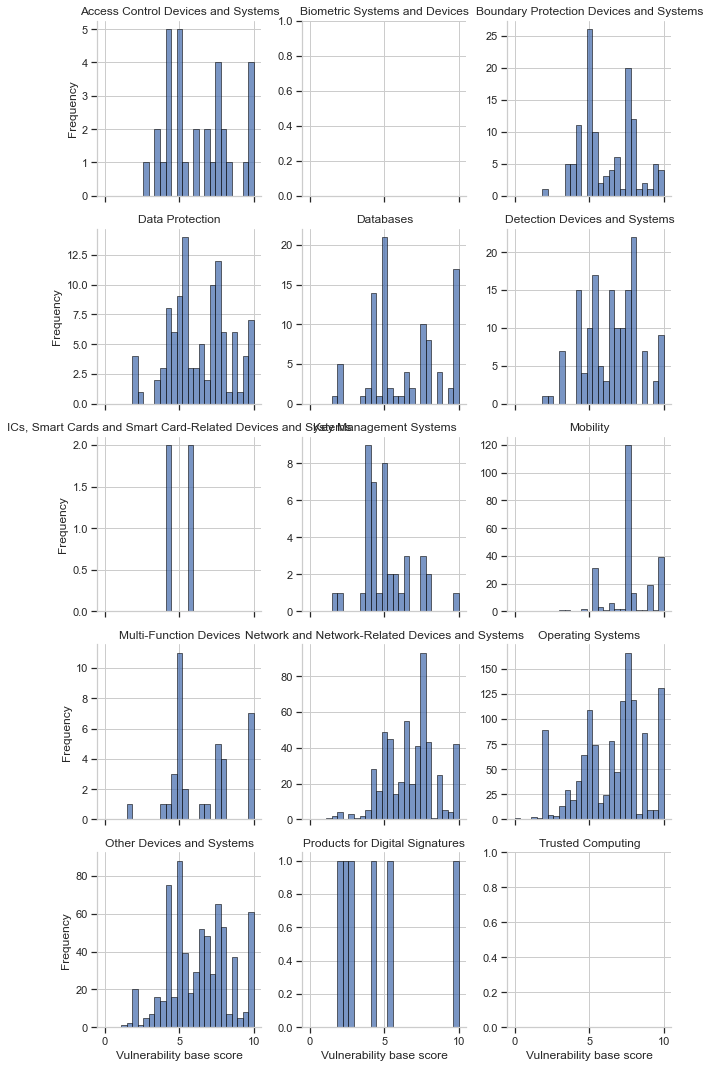

In [14]:
cves = cves.reset_index()  # See https://github.com/mwaskom/seaborn/issues/2733
g = sns.displot(data=cves, x="base_score", col="category", col_wrap=3, height=3, kind="hist", facet_kws={"sharey": False, "sharex": True})
g.set_titles("{col_name}")
# g.set_xticklabels(rotation=60)
g.set_axis_labels("Vulnerability base score", "Frequency")
g.tight_layout()
plt.savefig(RESULTS_DIR / "hist_category_vs_cve.pdf", bbox_inches='tight')

## Protection-profiles vs CVEs

Computes Pearson's correlation coefficient between number of CVEs and binary variable: Has a protection profile (1) or has not a protection profile (0)
Beware, number of supporting certificates may be quite low

In [15]:
df_cve_rich["has_pp"] = df_cve_rich.protection_profiles.isna()
corrs = df_cve_rich.groupby("category")[["n_cves", "has_pp"]].corr().iloc[0::2,-1].droplevel(level=1)
corrs.name = "correlation"
support_counts = df_cve_rich.groupby("category").size()
support_counts.name = "n certs in category"
pp_rich_counts = df_cve_rich.loc[df_cve_rich.has_pp == True].groupby("category").size()
pp_rich_counts.name = "n certs with PP"
pp_n_cves_corr = pd.concat([corrs, support_counts, pp_rich_counts], axis=1)

In [16]:
pp_n_cves_corr

,correlation,n certs in category,n certs with PP
category,,,
Access Control Devices and Systems,0.201211,15,13
Biometric Systems and Devices,NaN,0,0
Boundary Protection Devices and Systems,-0.224867,28,17
Data Protection,0.115856,10,7
Databases,0.266130,7,6
Detection Devices and Systems,0.043327,7,5
"ICs, Smart Cards and Smart Card-Related Devices and Systems",NaN,23,1
Key Management Systems,0.839556,4,3
Mobility,-0.042186,11,2


## CWEs in vulnerable certificates

- Study distribution of [CWEs](https://cwe.mitre.org/) in vulnerable certificates. 
- Experiment mainly with distribution across categories and security level. 
- Compare our results with findings from [open-source projects](https://dl.acm.org/doi/pdf/10.1145/3133956.3134072).
- Limit only to vulns. that were disclosed in the validity period of a certificate

In [17]:
cc_df, cwe_df = prepare_cwe_df(df_cves_within_validity_period.loc[df_cves_within_validity_period.n_cves > 0], cve_dset, fine_grained=True)

Filtering 2418 CVEs that have no CWE assigned. This affects 182 certificates
Still left with analysis of 4932 CVEs in 246 certificates.


In [18]:
cc_df

,cert_dgst,eal,cve_id,category,cwe_id
0,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40708,Boundary Protection Devices and Systems,CWE-125
1,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40709,Boundary Protection Devices and Systems,CWE-125
2,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40707,Boundary Protection Devices and Systems,CWE-125
3,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40710,Boundary Protection Devices and Systems,CWE-59
17,7709221bfec82ad9,EAL2+,CVE-2021-25252,Detection Devices and Systems,CWE-400
...,...,...,...,...,...
15183,5f1df5ad8e51ba75,EAL2+,CVE-2007-4613,Other Devices and Systems,CWE-310
15188,5f1df5ad8e51ba75,EAL2+,CVE-2008-0902,Other Devices and Systems,CWE-79
15191,5f1df5ad8e51ba75,EAL2+,CVE-2008-3257,Other Devices and Systems,CWE-119
15194,5f1df5ad8e51ba75,EAL2+,CVE-2008-0900,Other Devices and Systems,CWE-264


In [19]:
cwe_df

,cwe_name,cwe_description,type,child_of,url
cwe_id,,,,,
CWE-1004,Sensitive Cookie Without 'HttpOnly' Flag,The software uses a cookie to store sensitive ...,weakness,{CWE-732},https://cwe.mitre.org/data/definitions/1004.html
CWE-1007,Insufficient Visual Distinction of Homoglyphs ...,The software displays information or identifie...,weakness,{CWE-451},https://cwe.mitre.org/data/definitions/1007.html
CWE-102,Struts: Duplicate Validation Forms,The application uses multiple validation forms...,weakness,"{CWE-20, CWE-694, CWE-1173}",https://cwe.mitre.org/data/definitions/102.html
CWE-1021,Improper Restriction of Rendered UI Layers or ...,The web application does not restrict or incor...,weakness,"{CWE-441, CWE-610, CWE-451}",https://cwe.mitre.org/data/definitions/1021.html
CWE-1022,Use of Web Link to Untrusted Target with windo...,The web application produces links to untruste...,weakness,{CWE-266},https://cwe.mitre.org/data/definitions/1022.html
...,...,...,...,...,...
CWE-994,SFP Secondary Cluster: Tainted Input to Variable,This category identifies Software Fault Patter...,category,NaN,https://cwe.mitre.org/data/definitions/994.html
CWE-995,SFP Secondary Cluster: Feature,This category identifies Software Fault Patter...,category,NaN,https://cwe.mitre.org/data/definitions/995.html
CWE-996,SFP Secondary Cluster: Security,This category identifies Software Fault Patter...,category,NaN,https://cwe.mitre.org/data/definitions/996.html


In [20]:
# Print top-25 CWEs across dataset
top_25_cwes = get_top_n_cwes(cc_df, cwe_df, n_cwes=25)
top_25_cwes

,frequency,cwe_name,cwe_description,url,type
cwe_id,,,,,
CWE-119,875,Improper Restriction of Operations within the ...,The software performs operations on a memory b...,https://cwe.mitre.org/data/definitions/119.html,weakness
CWE-269,757,Improper Privilege Management,"The software does not properly assign, modify,...",https://cwe.mitre.org/data/definitions/269.html,weakness
CWE-20,652,Improper Input Validation,"The product receives input or data, but it doe...",https://cwe.mitre.org/data/definitions/20.html,weakness
CWE-787,650,Out-of-bounds Write,"The software writes data past the end, or befo...",https://cwe.mitre.org/data/definitions/787.html,weakness
CWE-200,612,Exposure of Sensitive Information to an Unauth...,The product exposes sensitive information to a...,https://cwe.mitre.org/data/definitions/200.html,weakness
CWE-125,326,Out-of-bounds Read,"The software reads data past the end, or befor...",https://cwe.mitre.org/data/definitions/125.html,weakness
CWE-264,287,"Permissions, Privileges, and Access Controls",Weaknesses in this category are related to the...,https://cwe.mitre.org/data/definitions/264.html,category
CWE-362,279,Concurrent Execution using Shared Resource wit...,The program contains a code sequence that can ...,https://cwe.mitre.org/data/definitions/362.html,weakness
CWE-416,196,Use After Free,Referencing memory after it has been freed can...,https://cwe.mitre.org/data/definitions/416.html,weakness


In [21]:
# Store top-10 CWEs into CSVs, do this also per category
CWE_DIR = RESULTS_DIR / "cwes"
CWE_DIR.mkdir(exist_ok=True)
top_25_cwes.to_csv(CWE_DIR / "top_25_cwe_overall.csv")

for cat in cc_df.category.unique():
    get_top_n_cwes(cc_df, cwe_df, category=cat).to_csv(CWE_DIR / (cat + ".csv"))

# Same for EALs
for eal in cc_df.eal.unique():
    get_top_n_cwes(cc_df, cwe_df, eal=eal).to_csv(CWE_DIR / (eal + ".csv"))

In [22]:
# For more coarse-grained description of CVEs, one could use so-called Security Fault Patterns (SFP) clusters.
from sec_certs.utils.pandas import SFPModel
model = SFPModel.from_web()
model.search_cwe(626) # <-- This returns Primary Cluster and Secondary cluster

('Tainted Input', 'SFP Secondary Cluster: Tainted Input to Command')

## CWE evolution in time

the following plot shows how top-10 overall CWEs evolve in time. As can be seen from the plot, the distribution is quite stable except for `CWE-119`. We assume that this can be caused by favoring different CWEs for similar problems, so it does not necessarilly correspond to certain weakness being eliminated recently in the coe, but even this may be the case.

In [23]:
cc_df.head()

,cert_dgst,eal,cve_id,category,cwe_id
0,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40708,Boundary Protection Devices and Systems,CWE-125
1,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40709,Boundary Protection Devices and Systems,CWE-125
2,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40707,Boundary Protection Devices and Systems,CWE-125
3,3dc6e1ebe7dd5584,EAL2+,CVE-2022-40710,Boundary Protection Devices and Systems,CWE-59
17,7709221bfec82ad9,EAL2+,CVE-2021-25252,Detection Devices and Systems,CWE-400


/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_74518/92252717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_df["vuln_year"] = cc_df.cve_id.map(lambda x: int(x.split("-")[1]))


Text(0.5, 1.0, 'CWE prevalence in time')

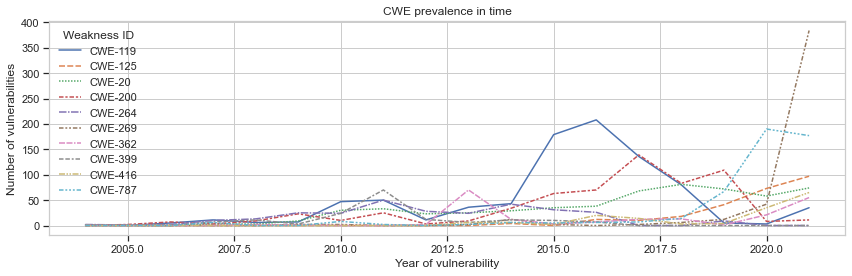

In [30]:
cc_df["vuln_year"] = cc_df.cve_id.map(lambda x: int(x.split("-")[1]))
cc_df = cc_df.loc[cc_df.vuln_year < 2022]
top_10_cwes = set(get_top_n_cwes(cc_df, cwe_df, n_cwes=10).index.tolist())
top_10_cwes = cc_df.loc[cc_df.cwe_id.isin(top_10_cwes)]
pivot = top_10_cwes.groupby(["vuln_year", "cwe_id"], as_index=False).size().rename(columns={"size": "frequency"}).pivot("vuln_year", "cwe_id", "frequency").fillna(0)
sns.lineplot(data=pivot)
plt.xlabel("Year of vulnerability")
plt.ylabel("Number of vulnerabilities")
plt.legend(title="Weakness ID")
plt.title("CWE prevalence in time")

## Print commands for LaTeX file

In [87]:
def get_n_rules(dct):
    if isinstance(dct, list):
        return len(dct)
    if isinstance(list(dct.values())[0], dict):
        return sum([get_n_rules(x) for x in dct.values()])
    else:
        return sum([len(x) for x in dct.values()])
    
n_regular_expressions = get_n_rules(cc_rules)

n_all_cpes = len(cpe_dset)
n_short_cpes = len([x for x in cpe_dset if x.item_name is not None and not len(x.item_name) > 3])

n_smartcards_vulnerable = len(df_cve_rich.loc[df_cve_rich.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"])
unique_smartcard_cves = set(itertools.chain.from_iterable(df_cve_rich.loc[df_cve_rich.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"].related_cves.tolist()))

df_cve_rich["roca"] = df_cve_rich.related_cves.map(lambda x: "CVE-2017-15361" in x)
df_cve_rich["titan"] = df_cve_rich.related_cves.map(lambda x: "CVE-2021-3011" in x)
df_cve_rich["minerva"] = df_cve_rich.related_cves.map(lambda x: "CVE-2019-15809" in x)
df_cve_rich["tmpfail"] = df_cve_rich.related_cves.map(lambda x: "CVE-2019-16863" in x)

n_roca_certs = df_cve_rich.roca.value_counts()[True]
n_titan_certs = df_cve_rich.titan.value_counts()[True]

try:
    n_minerva_certs = df_cve_rich.minerva.value_counts()[True]
except KeyError:
    n_minerva_certs = 0

try:
    n_tmpfail_certs = df_cve_rich.tmpfail.value_counts()[True]
except KeyError:
    n_tmpfail_certs = 0

n_cves_in_validity_period = exploded_cves.loc[(exploded_cves.cve_published_date > exploded_cves.not_valid_before) & (exploded_cves.cve_published_date < exploded_cves.not_valid_after)].shape[0]
n_cves_all = exploded_cves.shape[0]

print(f"\\newcommand{{\\numCCActiveVulnerable}}{{${df_cve_rich.loc[df_cve_rich.status == 'active'].shape[0]}$}}")
print(f"\\newcommand{{\\numCCArchivedVulnerable}}{{${df_cve_rich.loc[df_cve_rich.status == 'archived'].shape[0]}$}}")
print(f"\\newcommand{{\\fractionCPEShort}}{{${(100 * n_short_cpes / n_all_cpes):.2f}\%$}}  % number CPE strings with <4 characters.")
print(f"\\newcommand{{\\numRegularExpressions}}{{${n_regular_expressions}$}}")
print(f"\\newcommand{{\\numSmartcardsVulnerable}}{{${n_smartcards_vulnerable}$}}")
print(f"\\newcommand{{\\numSmartcardsDistinctVulnerabilities}}{{${len(unique_smartcard_cves)}$}}")
print(f"\\newcommand{{\\numSmartcardsRocaVuln}}{{${n_roca_certs}$}}")
print(f"\\newcommand{{\\numSmartcardsTitanVuln}}{{${n_titan_certs}$}}")
print(f"\\newcommand{{\\numSmartcardsMinervaVuln}}{{${n_minerva_certs}$}}")
print(f"\\newcommand{{\\numSmartcardsTmpFailVuln}}{{${n_tmpfail_certs}$}}")
print(f"\\newcommand{{\\numCertsWithMaintenance}}{{${df.loc[df.n_maintenances > 0].shape[0]}$}}")
print(f"\\newcommand{{\\numVulnerableCertsWithMaintenance}}{{${df_cve_rich.loc[df_cve_rich.n_maintenances > 0].shape[0]}$}}")
print(f"\\newcommand{{\\numCertsRevokedWithinYear}}{{${df_w_validity_dates.shape[0]}$}}")
print(f"\\newcommand{{\\numVulnerableCertsRevokedWithinYear}}{{${maybe_revoked.shape[0]}$}}")
print(f"\\newcommand{{\\numVulnerableCertsInValidityPeriod}}{{${(100 * n_cves_in_validity_period / n_cves_all):.0f}\%$}}")

name_mapping = {
    "Improper Restriction of Operations within the Bounds of a Memory Buffer": "Buffer overflow",
    "Exposure of Sensitive Information to an Unauthorized Actor": "Sensitive information exposure",
    "Permissions, Privileges, and Access Controls": "Access control error",
    "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')": "Cross-site Scripting",
    "Concurrent Execution using Shared Resource with Improper Synchronization ('Race Condition')": "Race Condition",
}

top_10_cwes = get_top_n_cwes(cc_df, cwe_df, n_cwes=10)
top_10_cwes.cwe_name = top_10_cwes.cwe_name.map(lambda x: name_mapping.get(x, x))
top_10_cwes.to_csv(RESULTS_DIR / "top_10_cwes.csv")

print(f"\nTable of CWEs follows:\n")

for cwe_id, row in top_10_cwes.iterrows():
    print(f"{cwe_id}\t & {row['cwe_name']} \t & {row['frequency']} \\\\")

print(f"\nTable of correlations follows:\n")

for sar, row in df_corr.iterrows():
    color_n_cves = "\cellcolor{green!15}" if row['n_cves_pvalue'] < 0.01 else ""
    color_avg_score = "\cellcolor{green!15}" if row['avg_cve_pvalue'] < 0.01 else ""
    print(f"{sar} & {color_n_cves} {row['n_cves_corr']:.2f} & {color_n_cves} {row['n_cves_pvalue']:.2e} & {color_avg_score} {row['avg_cve_score_corr']:.2f} & {color_avg_score} {row['avg_cve_pvalue']:.2e} & {row['support']:.0f} & {row['range']:.0f} \\\\")

\newcommand{\numCCActiveVulnerable}{$106$}
\newcommand{\numCCArchivedVulnerable}{$270$}
\newcommand{\fractionCPEShort}{$4.47\%$}  % number CPE strings with <4 characters.
\newcommand{\numRegularExpressions}{$485$}
\newcommand{\numSmartcardsVulnerable}{$23$}
\newcommand{\numSmartcardsDistinctVulnerabilities}{$2$}
\newcommand{\numSmartcardsRocaVuln}{$16$}
\newcommand{\numSmartcardsTitanVuln}{$7$}
\newcommand{\numSmartcardsMinervaVuln}{$0$}
\newcommand{\numSmartcardsTmpFailVuln}{$0$}
\newcommand{\numCertsWithMaintenance}{$361$}
\newcommand{\numVulnerableCertsWithMaintenance}{$24$}
\newcommand{\numCertsRevokedWithinYear}{$39$}
\newcommand{\numVulnerableCertsRevokedWithinYear}{$2$}
\newcommand{\numVulnerableCertsInValidityPeriod}{$50\%$}

Table of CWEs follows:

CWE-119	 & Buffer overflow 	 & 863 \\
CWE-200	 & Sensitive information exposure 	 & 608 \\
CWE-20	 & Improper Input Validation 	 & 582 \\
CWE-787	 & Out-of-bounds Write 	 & 490 \\
CWE-269	 & Improper Privilege Management 	 & 466 \\


In [59]:
df_corr

,n_cves_corr,n_cves_pvalue,avg_cve_score_corr,avg_cve_pvalue,support,range
EAL/SAR family,,,,,,
EAL,-0.026750,7.929923e-02,-0.348873,2.526833e-07,2779,14
ALC\_CMC,-0.102765,3.222375e-07,-0.368044,4.122288e-08,2336,5
ALC\_CMS,-0.099041,7.843342e-07,-0.367196,4.436660e-08,2342,5
AVA\_VAN,-0.108667,5.797582e-08,-0.351478,1.787198e-07,2367,4
ATE\_IND,-0.083390,1.772333e-06,-0.328926,2.223989e-08,3083,3
ATE\_COV,-0.020569,1.621168e-01,-0.317541,2.026090e-05,2299,3
ADV\_FSP,-0.079044,4.737295e-06,-0.279932,2.007287e-06,3132,6
ASE\_OBJ,-0.115048,3.066473e-07,-0.137514,4.145539e-02,1869,2
ASE\_REQ,-0.117490,1.336536e-07,-0.119977,6.297902e-02,1907,2


EAL &  -0.03 &  7.93e-02 & \cellcolor{green!15} -0.35 & \cellcolor{green!15} 2.53e-07 & 2779 & 14 \\
ALC\_CMC & \cellcolor{green!15} -0.10 & \cellcolor{green!15} 3.22e-07 & \cellcolor{green!15} -0.37 & \cellcolor{green!15} 4.12e-08 & 2336 & 5 \\
ALC\_CMS & \cellcolor{green!15} -0.10 & \cellcolor{green!15} 7.84e-07 & \cellcolor{green!15} -0.37 & \cellcolor{green!15} 4.44e-08 & 2342 & 5 \\
AVA\_VAN & \cellcolor{green!15} -0.11 & \cellcolor{green!15} 5.80e-08 & \cellcolor{green!15} -0.35 & \cellcolor{green!15} 1.79e-07 & 2367 & 4 \\
ATE\_IND & \cellcolor{green!15} -0.08 & \cellcolor{green!15} 1.77e-06 & \cellcolor{green!15} -0.33 & \cellcolor{green!15} 2.22e-08 & 3083 & 3 \\
ATE\_COV &  -0.02 &  1.62e-01 & \cellcolor{green!15} -0.32 & \cellcolor{green!15} 2.03e-05 & 2299 & 3 \\
ADV\_FSP & \cellcolor{green!15} -0.08 & \cellcolor{green!15} 4.74e-06 & \cellcolor{green!15} -0.28 & \cellcolor{green!15} 2.01e-06 & 3132 & 6 \\
ASE\_OBJ & \cellcolor{green!15} -0.12 & \cellcolor{green!15} 3.07e-07

In [ ]:
df.loc[(df.related_cves.notnull()) & ((df.not_valid_before.isnull()) | (df.not_valid_after.isnull()))]

,cert_id,name,status,category,manufacturer,scheme,security_level,eal,not_valid_before,not_valid_after,...,protection_profiles,cert_lab,year_from,n_maintenances,maintenance_dates,n_cves,cve_published_dates,earliest_cve,worst_cve_score,avg_cve_score
ebd276cca70fd723,BSI-DSZ-CC-0683-2014,IBM Security Access Manager for Enterprise Sin...,active,Access Control Devices and Systems,IBM Corporation,DE,"{EAL3+, ALC_FLR.1}",EAL3+,2014-12-05,NaT,...,NaN,BSI,2014,NaN,NaN,6,"[2013-12-22, 2013-12-22, 2019-08-26, 2018-08-1...",2013-12-22,10.0,5.800000
b7f814ed16f2ecca,CSEC2016009,Clavister cOS Core v12.00.00,active,Boundary Protection Devices and Systems,Clavister AB,SE,"{EAL4, ALC_FLR.1}",EAL4,2019-06-19,NaT,...,NaN,NaN,2019,NaN,NaN,1,[2018-08-15],2018-08-15,5.9,5.900000
4fc1208e4c800aa6,CSEC2015010,WatchGuard Firebox Security Appliances with Fi...,active,Boundary Protection Devices and Systems,"WatchGuard Technologies, Inc.",SE,"{EAL4, ALC_FLR.2}",EAL4,2017-05-05,NaT,...,NaN,NaN,2017,NaN,NaN,2,"[2017-09-20, 2017-09-20]",2017-09-20,7.5,6.800000
c8f2a5312b671aae,ISCB-5-RPT-C069-CR-v1,MarkLogic Server 8.0-4,active,Databases,MarkLogic Corporation,MY,"{ALC_FLR.3, EAL2+}",EAL2+,2015-12-22,NaT,...,NaN,NaN,2015,NaN,NaN,11,"[2017-05-23, 2017-05-24, 2018-09-07, 2017-05-2...",2017-05-23,9.6,8.309091
4c33266562bb9b24,CSEC2017009,HP LaserJet Managed MFP E62555/E62565/E62575/E...,active,Multi-Function Devices,HP Inc.,SE,"{EAL3, ALC_FLR.2}",EAL3,2019-10-11,NaT,...,NaN,NaN,2019,NaN,NaN,3,"[2021-11-03, 2021-10-29, 2021-11-03]",2021-10-29,9.8,6.600000
592a45cf16b66c1b,CSEC2016006,Intrusion Detection in the HP Enterprise Laser...,active,Multi-Function Devices,HP Inc.,SE,"{EAL2, ALC_FLR.2}",EAL2,2019-05-24,NaT,...,NaN,NaN,2019,NaN,NaN,3,"[2021-11-03, 2021-10-29, 2021-11-03]",2021-10-29,9.8,6.600000
43610aed20f29542,CSEC2015002,HP Color LaserJet Enterprise M553 Printer Seri...,active,Multi-Function Devices,HP Inc.,SE,"{EAL2+, ALC_FLR.2}",EAL2+,2015-10-06,NaT,...,[IEEE Standard Protection Profile for Hardcopy...,NaN,2015,NaN,NaN,2,"[2009-03-18, 2009-03-18]",2009-03-18,7.6,6.350000
547e899b9b5eabae,ISCB-5-RPT-C076-CR-v1,Hewlett Packard Enterprise ArcSight Enterprise...,active,Network and Network-Related Devices and Systems,Hewlett Packard Enterprise,MY,{EAL2},EAL2,2016-12-14,NaT,...,NaN,NaN,2016,1.0,[2017-07-14 00:00:00],9,"[2017-09-30, 2017-10-31, 2017-10-31, 2017-09-3...",2017-09-30,9.8,6.644444
e75c31ba27f12f29,ISCB-3-RPT-C073-CR-v1,RSA Archer GRC Platform version 6.1,active,Network and Network-Related Devices and Systems,"RSA, The Security Division of EMC",MY,"{EAL2+, ALC_FLR.2}",EAL2+,2016-09-14,NaT,...,NaN,NaN,2016,NaN,NaN,29,"[2017-10-11, 2019-09-18, 2022-06-02, 2017-10-1...",2017-10-11,9.8,6.327586
a92fe4e09a418288,2014-43-INF-1560,HP Asset Manager v9.50 with Connect-It v9.60 b...,active,Network and Network-Related Devices and Systems,"Hewlett-Packard Development Company, L.P.",ES,"{EAL2+, ALC_FLR.2}",EAL2+,2016-05-27,NaT,...,NaN,NaN,2016,1.0,[2016-09-27 00:00:00],2,"[2016-04-05, 2020-02-04]",2016-04-05,9.8,8.650000


In [57]:
df_cve_rich.loc[df_cve_rich.titan]

,cert_id,name,status,category,manufacturer,scheme,security_level,eal,not_valid_before,not_valid_after,...,n_cves,cve_published_dates,earliest_cve,worst_cve_score,avg_cve_score,has_pp,roca,titan,minerva,tmpfail
2793414918738c7f,NSCIB-CC-13-37761-CR2,"J3E081_M64, J3E081_M66, J2E081_M64, J3E041_M66...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,NL,"{ASE_TSS.2, AVA_VAN.5, ALC_DVS.2, EAL5+}",EAL5+,2014-08-26,2018-08-05,...,1,[2021-01-07],2021-01-07,4.2,4.2,False,False,True,False,False
dbe20d7c305b24eb,NSCIB-CC-13-37760-CR2,"J3E145_M64, J3E120_M65, J3E082_M65, J2E145_M64...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,NL,"{ASE_TSS.2, AVA_VAN.5, ALC_DVS.2, EAL5+}",EAL5+,2014-08-26,2018-08-05,...,1,[2021-01-07],2021-01-07,4.2,4.2,False,False,True,False,False
559a5c3c4c23a9d3,NSCIB-CC-13-37762,"J3E081_M64_DF, J3E081_M66_DF, J3E041_M66_DF, J...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,NL,"{ASE_TSS.2, AVA_VAN.5, ALC_DVS.2, EAL4+}",EAL4+,2013-10-16,2018-10-16,...,1,[2021-01-07],2021-01-07,4.2,4.2,False,False,True,False,False
861434b03ddcac64,BSI-DSZ-CC-0784-2013,"NXP J3D081_M59, J2D081_M59, J3D081_M61, J2D081...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"{ASE_TSS.2, AVA_VAN.5, ALC_DVS.2, EAL5+}",EAL5+,2013-07-31,2019-09-01,...,1,[2021-01-07],2021-01-07,4.2,4.2,False,False,True,False,False
8cfd0c9f4bcd21b8,BSI-DSZ-CC-0860-2013,NXP J3D081_M59_DF and J3D081_M61_DF Secure Sma...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"{ASE_TSS.2, AVA_VAN.5, ALC_DVS.2, EAL4+}",EAL4+,2013-07-31,2019-09-01,...,1,[2021-01-07],2021-01-07,4.2,4.2,False,False,True,False,False
b24a14935edd51ad,BSI-DSZ-CC-0783-2013,"NXP J3D145_M59, J2D145_M59, J3D120_M60, J3D082...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"{ASE_TSS.2, AVA_VAN.5, ALC_DVS.2, EAL5+}",EAL5+,2013-07-31,2019-09-01,...,1,[2021-01-07],2021-01-07,4.2,4.2,False,False,True,False,False
36ed04f4b45e3ab9,BSI-DSZ-CC-0675-2011,"NXP J3A081, J2A081 and J3A041 Secure Smart Car...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"{AVA_VAN.5, ALC_DVS.2, EAL5+}",EAL5+,2011-04-06,2019-09-01,...,1,[2021-01-07],2021-01-07,4.2,4.2,True,False,True,False,False
